# Perceptron classifier
-----------
Reproducing the results shown in lecture 15 of the amazing "Information Theory, Pattern Recognition, and Neural Networks" series by David MacKay ([youtube link](https://youtu.be/Z1pcTxvCOgw)).

## Problem framing
Simple classification problem with $N=10$ data points living in a $D=2$ dimensional space $\left\{x_d^{(n)}\right\}_{\substack{d=1,...,D}\\{n=1,...,N}}$.
Targets are binary $t_n \in \left\{0,1\right\}^N$

In [1]:
using Plots, LinearAlgebra
gr(width=3);

Plot data

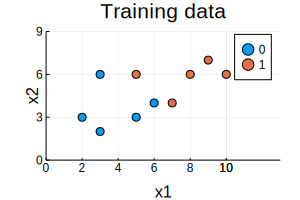

In [2]:
x = Float64.([3 2 5 3 6 5 7 8 9 10;
              2 3 3 6 4 6 4 6 7 6])
t = Bool.([0,0,0,0,0,1,1,1,1,1])
plt = scatter(x[1,t.==0],x[2,t.==0], label = "0")
scatter!(x[1,t.==1],x[2,t.==1], label = "1", size=(300,200))
title!("Training data")
xlims!((0,13)); ylims!((0,9));
xlabel!("x1"); ylabel!("x2")
display(plt)

## Naive perceptron learning
------------

We have a perceptron with a set of weights $\left\{w_d\right\}_{d=1}^D$ and a bias $w_0$ that performs
$$y = f(a)$$
where
$$a = \sum_{d=1}^D w_d x_d^{(n)} + w_0$$
and
$$ f(a) = \frac{1}{1+e^{-a}}$$
is the sigmoid function.

All in all,
$$y_n = \frac{1}{1+\exp\left[-\left(w_0 + w_1 x_1^{(n)} + w_2 x_2^{(n)}\right)\right]}$$

---------------
As energy (cost) function we choose cross-entropy, as usual in binary classification problems
$$E_P(\underline{w}) = - \sum\limits_{n=1}^N\left\{ t_n \log y_n + (1-t_n)\log(1-y_n) \right\}$$
and look for
$$ \underline{w}^* \in \arg\min_{\underline{w}}E_P(\underline{w})$$

The easiest approach is gradient descent. Computing the gradient gives
$$\underline{g} = \left( g_0, g_1, g_2 \right) = \frac{\partial E_P}{\partial \underline{w}} = -\sum\limits_n (t_n - y_n) \tilde{\underline{x}}^{(n)}$$
where $\tilde{\underline{x}}^{(n)}$ is an extension of $\underline{x}^{(n)}$ which accounts for the bias
$$ \tilde{\underline{x}}^{(n)} = \left( 1, x_1^{(n)}, x_2^{(n)} \right)$$

Gradient descent is performed by iteratively subtracting the gradient times a learning rate $\eta$
$$ \underline{w} \leftarrow  \underline{w} -\eta \underline{g}$$

In [4]:
f(a) = 1/(1+exp(-a))

function yn(w::Vector{Float64}, xn::Vector{Float64}, func::Function)
    a = w[1] + w[2]*xn[1] + w[3]*xn[2]
    return func(a)
end

function EP(w::Vector{Float64}, x::Array{Float64,2}, t::AbstractArray{Bool}, Yn::Function, func::Function)
    return -sum(t[n]*log(Yn(w,x[:,n],func)) + (1-t[n])*(log(1-Yn(w,x[:,n],func))) for n in eachindex(t))
end

function g(w::Vector{Float64}, x::Array{Float64,2}, t::AbstractArray{Bool}, Yn::Function, func::Function)
    nweights = length(w)
    gd = zeros(nweights)
    gd[1] = -sum(t[n] - Yn(w,x[:,n],func) for n in eachindex(t))
    for d in 2:nweights
        gd[d] = -sum((t[n] - Yn(w,x[:,n],func))*x[d-1,n]  for n in eachindex(t))
    end
    return gd
end

function learnGD(w_init::Vector{Float64}, x::Array{Float64,2}, t::AbstractArray{Bool}, η::Float64, grad::Function, 
        Yn::Function, func::Function, energy::Function, niters::Int)
    
    w = zeros(length(w_init),niters+1)
    w[:,1] = w_init
    en = zeros(niters+1)
    en[1] = energy(w_init, x, t, Yn, func)
    for it in 1:niters
        gd = grad(w[:,it], x, t, Yn, func)
        w[:,it+1] = w[:,it] - η*gd
        en[it+1] = energy(w[:,it+1], x, t, Yn, func)
    end
    return w, en
end

learnGD (generic function with 1 method)

Start with random weights and run GD

In [5]:
w_init = randn(3)
η = 1e-2
niters = 10000
w, en = learnGD(w_init, x, t, η, g, yn, f, EP, niters)

([-1.47284 -1.42298 … -15.6553 -15.656; -1.48339 -1.09372 … 1.52985 1.52991; -0.0691583 0.220394 … 1.52102 1.52109], [67.236, 43.484, 20.8152, 7.38988, 7.00536, 6.83163, 6.68715, 6.55002, 6.41929, 6.29485  …  1.24703, 1.24698, 1.24693, 1.24689, 1.24684, 1.24679, 1.24674, 1.2467, 1.24665, 1.2466])

Plot energy and weights

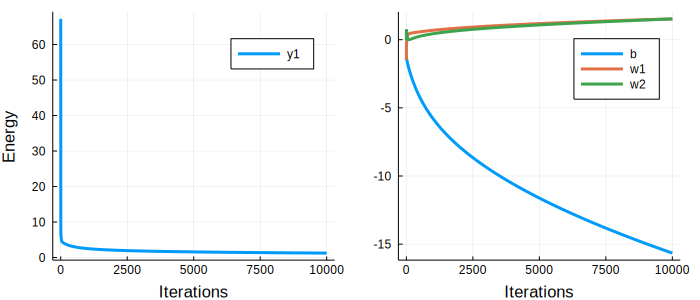

In [6]:
p1 = plot(0:niters, en, xlabel="Iterations", ylabel="Energy")
p2 = plot(0:niters, transpose(w), labels=["b", "w1", "w2"])
p3 = plot(p1, p2, xlabel="Iterations", size=(700,300))

Plot $y$ as a function of $x_1, x_2$ with the obtained weights

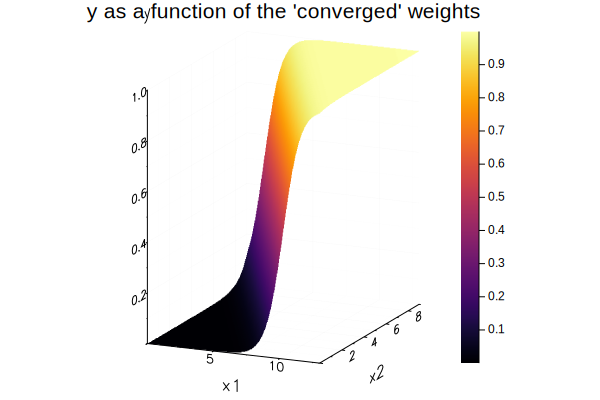

In [7]:
x1 = LinRange(0,13,100)
x2 = LinRange(0,9,100)
Y(x,y) = yn(w[:,end], [x,y], f)
z = [yn(w[:,end], [X1,X2],f) for X2 in x2, X1 in x1]
surface(x1,x2,z, xlabel="x1", ylabel="x2", zlabel="y", title="y as a function of the 'converged' weights")

A countour plot:

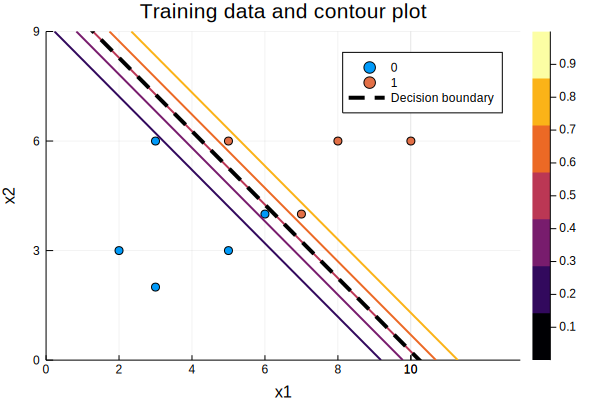

In [8]:
plt = scatter(x[1,t.==0],x[2,t.==0], label = "0")
scatter!(x[1,t.==1],x[2,t.==1], label = "1", size=(600,400))

title!("Training data and contour plot")
xlims!((0,13)); ylims!((0,9));
xlabel!("x1"); ylabel!("x2")
contour!(plt, x1, x2, z, width=2, levels=7)
plot!(x1, -(w[1,end] .+ w[2,end]*x1)/w[3,end], label="Decision boundary", width=4, color="black", style=:dash)

The plot of $y$ is extremely steep, which means the classifier is very confident about its choices. Should it? Probably not...

## Regularization

Add a penalty for large weights:
$$E_W(\underline{w}) = \alpha\sum_{d=0}^D w_d^2$$
with $\alpha$ to be chosen.
The full energy now looks like
$$E_R(\underline{w}) = - \sum\limits_{n=1}^N\left\{ t_n \log y_n + (1-t_n)\log(1-y_n) \right\} + \frac{\alpha}{2}\sum_{d=0}^D w_d^2$$
and the gradient has a new term
$$\underline{g}_R =  \alpha\underline{w}$$

In [9]:
function ER(w::Vector{Float64}, x::Array{Float64,2}, t::AbstractArray{Bool}, Yn::Function, 
        func::Function, α::Float64)
    
    return EP(w, x, t, Yn, func) + α/2*sum(abs2,w)
end

function learnGD_withR(w_init::Vector{Float64}, x::Array{Float64,2}, t::AbstractArray{Bool}, η::Float64, 
        grad::Function, Yn::Function, func::Function, energy::Function, niters::Int, α::Float64)
    
    w = zeros(length(w_init),niters+1)
    w[:,1] = w_init
    en = zeros(niters+1)
    en[1] = energy(w_init, x, t, Yn, func, α)
    for it in 1:niters
        gd = grad(w[:,it], x, t, Yn, func) + α*w[:,it]
        w[:,it+1] = w[:,it] - η*gd
        en[it+1] = energy(w[:,it+1], x, t, Yn, func, α)
    end
    return w, en
end

learnGD_withR (generic function with 1 method)

In [10]:
w_init = zeros(3)
η = 1e-2
α = 2e-2
niters = 10000
wR, enR = learnGD_withR(w_init, x, t, η, g, yn, f, ER, niters, α)

([0.0 0.0 … -8.08698 -8.08699; 0.0 0.1 … 0.875456 0.875458; 0.0 0.055 … 0.698687 0.698689], [6.93147, 6.58933, 6.44987, 6.39703, 6.35432, 6.31551, 6.27906, 6.24459, 6.21193, 6.18092  …  2.70241, 2.70241, 2.70241, 2.70241, 2.70241, 2.70241, 2.70241, 2.70241, 2.70241, 2.70241])

Plot energy and weights

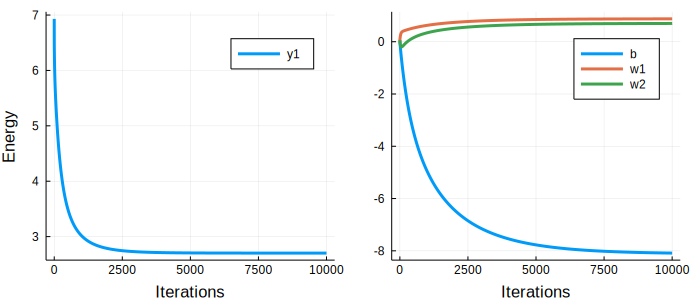

In [11]:
p1 = plot(0:niters, enR, xlabel="Iterations", ylabel="Energy")
p2 = plot(0:niters, transpose(wR), labels=["b", "w1", "w2"])
p3 = plot(p1, p2, xlabel="Iterations", size=(700,300))

Regularization flattens the curves for both energy and weights. 

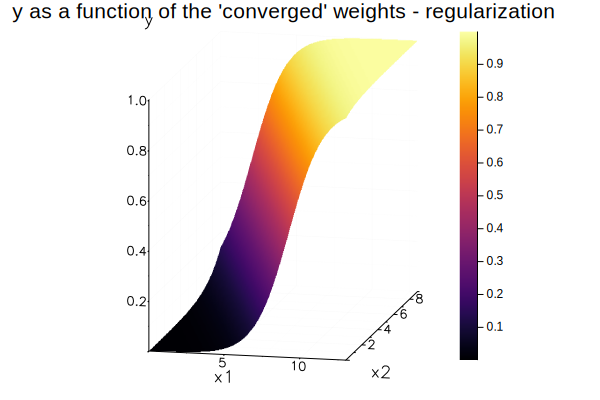

In [18]:
zR = [yn(wR[:,end], [X1,X2],f) for X2 in x2, X1 in x1]
surface(x1,x2,zR, xlabel="x1", ylabel="x2", zlabel="y", 
    title="y as a function of the 'converged' weights - regularization", camera=(20,30))

Contour plot:

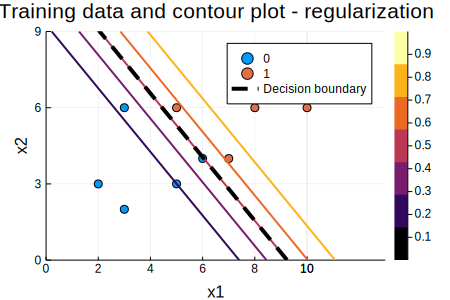

In [17]:
plt = scatter(x[1,t.==0],x[2,t.==0], label = "0")
scatter!(x[1,t.==1],x[2,t.==1], label = "1", size=(450,300))

title!("Training data and contour plot - regularization")
xlims!((0,13)); ylims!((0,9));
xlabel!("x1"); ylabel!("x2")
contour!(plt, x1, x2, zR, width=2, levels=7)
plot!(x1, -(wR[1,end] .+ wR[2,end]*x1)/wR[3,end], label="Decision boundary", width=4, color="black", style=:dash)

The boundary is now smoother!

There is still something we can do: here the classifier is making a rather confident decision in the regions of input space with no data points. Instead, it should be reasonable for it to express more uncertainty.

## Bayesian inference
------------
The key hypothesis is to interpret 
\begin{align}
E_R(\underline{w}) &= E_P(\underline{w}) + E_W(\underline{w})\\
&=- \sum\limits_{n=1}^N\left\{ t_n \log y_n + (1-t_n)\log(1-y_n) \right\} + \frac{\alpha}{2}\sum_{d=0}^D w_d^2\\
\end{align}
as the $-\log$ of a posterior probability distribution
$$ P(\underline{w}|x,t) = \frac{\exp\left(-\beta E_P(\underline{w})\right)\exp\left(-\alpha E_W(\underline{w})\right)}{Z}$$
where the likelihood
$$ P(t|\underline{w},x) =\exp\left(\beta E_P(\underline{w})\right)$$
is intractable because of the nasty form of $E_P$.
The prior on the is given by
$$P(\underline{w}) \propto \exp\left(-\alpha\frac{\sum_{d=0}^D w_d^2}{2}\right)$$
a multivariate Gaussian distribution.

Marginalizing, we can find the distribution for the class of a new observation $x^{(n+1)}$:
$$ P(t_{N+1}|t_1,...,t_N) = \int d\underline{w} P(t_{N+1}|\underline{w}) P(\underline{w}|t_1,...,t_N) $$
Now, in this probabilistic interpretation framework, $P(t_{N+1}|\underline{w})$ is nothing but $y(t_{N+1}|\underline{w})$.

So finally we have that the predictive distribution of the weights is the expectation value of a simple function ($y$) over a nasty distribution ($P(\underline{w}|t_1,...,t_N)$)
\begin{align}
P(t_{N+1}|t_1,...,t_N) &= \int d\underline{w} y(t_{N+1}|\underline{w}) P(\underline{w}|t_1,...,t_N) $\\
                       &\approx \frac{1}{M}\sum\limits_{m=1}^M y(t_{N+1}|\underline{w}^{(m)})
\end{align}
with $\underline{w}^{(m)}$ sampled from the distribution $P(\underline{w}|t_1,...,t_N)$ by running a Monte Carlo Markov Chain.

In [19]:
using Statistics, Random, Distributions

function log_peq(w, x, t)
    # Returns the log of the target probability
    alpha = 0.01
    beta = 1
    log_prior = -alpha*sum(abs2,w)/2
    log_likelihood = -beta*EP(w, x, t, yn, f)
    return log_prior, log_likelihood
end

function metrop(w_init, x, t, sigma, nsteps)
    nparams = length(w_init)
    w = zeros(nsteps, nparams)
    w_prev = w_init
    accept = falses(nsteps,nparams)
    energy = zeros(nsteps)
   for n in 1:nsteps
       for i in 1:nparams
            # propose a new value for one parameter
            w_new = copy(w_prev)
            w_new[i] = rand(Normal(w_new[i], sigma[i]))
            # accept with a certain probability
            if rand(Uniform()) < exp(sum(log_peq(w_new, x, t))-sum(log_peq(w_prev, x, t)))
                accept[n,i] = true
                w[n,:] = w_new
                w_prev = copy(w_new)
            else
                w[n,:] = w_prev
            end
        end
        energy[n] = sum(log_peq(w_prev, x, t))
    end
    return w, mean(accept, dims=1), energy
end

metrop (generic function with 1 method)

In [24]:
nsteps = 5000
sigma = [1.8, 0.3, 0.3]
w_init = randn(3)
wB, acc_ratio, enB = @time metrop(w_init, x, t, sigma, nsteps)

  0.112162 seconds (794.39 k allocations: 68.983 MiB, 16.85% gc time)


([1.81402 0.183783 -1.33413; 2.84157 0.295733 -1.07948; … ; -15.6045 1.48508 1.78255; -15.8677 1.70228 1.80929], [0.6038 0.617 0.6558], [-23.6484, -12.375, -10.5225, -7.42323, -7.64783, -7.54371, -7.54371, -7.60784, -7.06899, -7.0977  …  -2.80528, -5.20844, -3.65996, -2.56126, -2.79639, -3.26421, -3.22522, -3.01552, -2.94474, -4.00548])

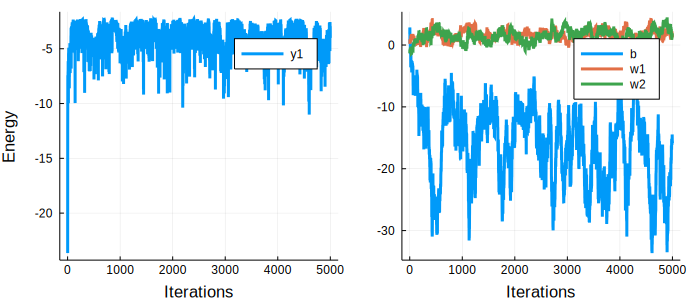

In [25]:
p1 = plot(1:nsteps, enB, xlabel="Iterations", ylabel="Energy")
p2 = plot(1:nsteps, wB, labels=["b", "w1", "w2"])
p3 = plot(p1, p2, layout = (1,2), xlabel="Iterations", size=(700,300))

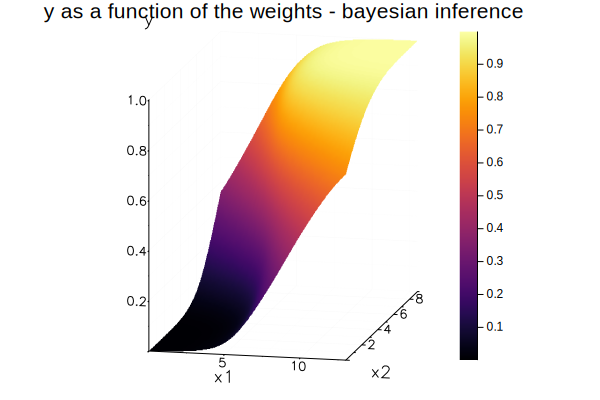

In [29]:
thermaliz = 25
zB = transpose([mean(yn(wB[n,:],[X1,X2],f) for n in thermaliz:nsteps) for (i,X1) in enumerate(x1), (j,X2) in enumerate(x2)])
surface(x1,x2,zB, xlabel="x1", ylabel="x2", zlabel="y", 
    title="y as a function of the weights - bayesian inference", camera=(20,30))

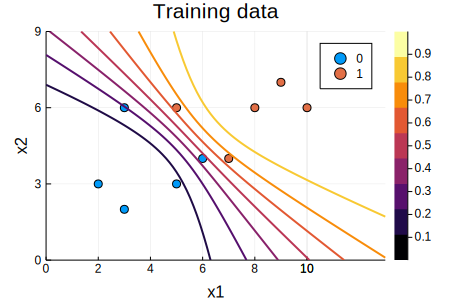

In [30]:
plt = scatter(x[1,t.==0],x[2,t.==0], label = "0")
scatter!(x[1,t.==1],x[2,t.==1], label = "1", size=(450,300))

title!("Training data")
xlims!((0,13)); ylims!((0,9));
xlabel!("x1"); ylabel!("x2")
contour!(plt, x1, x2, zB, width=2, levels=9)